# Homework 5: Neural Style Transfer Assignment

In this assignment, we will learn about Neural Style Transfer. This algorithm was created by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576). You will:

- Implement the neural style transfer (NST) algorithm
- Generate novel artistic images using the algorithm

In Neural Style Transfer, you will use a **pre-trained** model, e.g., vgg19, to optimize an **image** to minimize the combination of **content loss** and **sytle loss**.


# 0 - Useful Libraries
Below is a list of the libraries needed to implement the neural transfer.
- `torch`, `torch.nn`: indispensables packages for neural networks with PyTorch
- `torch.optim`: efficient gradient descents
- `PIL`, `PIL.Image`, `matplotlib.pyplot`: load and display images
- `torchvision.transforms`: transform PIL images into tensors
- `torchvision.models`: train or load pretrained models
- `tqdm.notebook`, `tqdm`: optional, display the progress bar

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optimization

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

from tqdm.notebook import tqdm

Next, we need to choose which device to run the network on and import the content and style images. Running the neural transfer algorithm on large images takes longer and will go much faster when running on a GPU. We can use `torch.cuda.is_available()` to detect if there is a GPU available. To ensure all *newly created tensors* and *models* are automatically placed on the correct device, we use `torch.set_default_device(device)`. This eliminates the need to explicitly call `.to(device)` for every tensor or model, making the code cleaner.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(f"Using device: {device}")

Using device: cuda


**Note**: `.to(device)` is still needed in certain cases, such as:
- Loading saved tensors (e.g., from a file) that were created on a different device.
- Interacting with external libraries (e.g., NumPy, PIL) that create CPU tensors.
- Manually transferring tensors between CPU and GPU when necessary.

# 1 - Loading the Images [10/10]

Here are links to download the images used in this assignment: [picasso.jpg](https://pytorch.org/tutorials/_static/img/neural-style/picasso.jpg) and [dancing.jpg](https://pytorch.org/tutorials/_static/img/neural-style/dancing.jpg). Download these two images and add them to a directory with name images in your current working directory. You are also encouraged to use your own style and content images.

In computer vision, image datasets typically have pixel values in the range `[0, 255]`. After loading an image, it is first rescaled to the range `[0, 1]` using `.ToTensor()`. Then, depending on the dataset, the image is further normalized to have a mean of $0$ and a standard deviation of $1$ to facilitate stable training.

Here, VGG networks are trained on the ImageNet dataset, which was preprocessed using a specific normalization. Each image, with 3 channels (RGB), is normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. To ensure consistency with VGG19’s training data, we apply this same normalization to the content, style, and generated images before passing them into the network.

**Exercise [5/5]**: Using `transforms` to define the image `loader` that converts images to tensors using `ToTensor()` and normalizes them using ImageNet `mean` and `std`.

In [ ]:
img_size = 512 if torch.cuda.is_available() else 128

# Define the mean and std values (as tensors)
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])

loader = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    ## Code Here ##

    )

def load_img(path):
  img = Image.open(path)
  img = loader(img).unsqueeze(0)
  return img.to(device)

In [ ]:
content_img = load_img('dancing.jpg')
style_img = load_img('picasso.jpg')

We have defined the function `img_loader()` to load an image and convert it into a torch.Tensor and also normalize them using ImageNet mean and std. Now, let’s create a function that displays an image by converting it back to PIL format and using plt.imshow for visualization.

Since the input tensor has been normalized, we need to properly handle denormalization:
- When an image is normalized during preprocessing (e.g., for VGG models), its pixel values are transformed as:

$$X_{\text{norm}} = \frac{X - \text{mean}}{\text{std}}$$

- To reverse this normalization before displaying the image, we use:

$$
X_{\text{denorm}} = (X_{\text{norm}} \times \text{std}) + \text{mean}
$$

Actually, denormalization is mathematically equivalent to normalization using:
- The **negative mean** as the new mean.
- The **reciprocal of std** as the new std.

$$
\begin{align}
X_{\text{denorm}} &= X_{\text{norm}} \times \text{std} + \text{mean} \\
&= \text{std} \times (X_{\text{norm}} + \text{mean} / \text{std}) \\
&= \frac{X_{\text{norm}} - (-\text{mean} / \text{std})}{1 / \text{std}}
\end{align}
$$

This insight allows us to implement denormalization using `transforms.Normalize()`, just like normalization.

**Exercise [5/5]**: Implement the `img_show`

In [ ]:
# Transformation to convert tensor to PIL Image
unloader = transforms.ToPILImage()

def img_show(tensor, title=None):
    # Define denormalization transform
    ## Code Here ##
    denormalization =
    ## Code Here ##

    img = tensor.clone().detach().cpu().squeeze(0)  # Remove batch dimension
    img = denormalization(img).clamp(0, 1)  # Denormalize and clamp values
    img = unloader(img)  # Convert to PIL image
    plt.imshow(img)
    plt.axis("off")  # Hide axes
    if title:
        plt.title(title)
    plt.show()

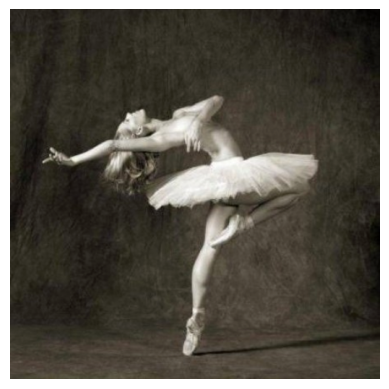

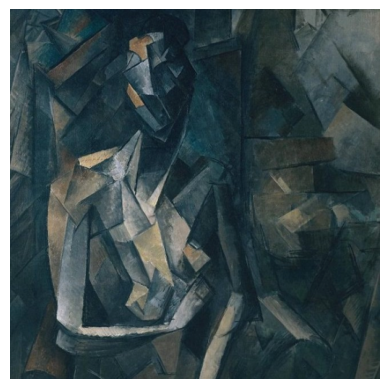

In [ ]:
plt.figure()
img_show(content_img)
plt.figure()
img_show(style_img)

# 2 - Importing the Pre-Trained Model [20/20]

Now we need to import a pretrained neural network. We will use a 19 layer VGG network in this assignment.

PyTorch’s implementation of VGG is a module divided into two child `Sequential` modules:
- `features`: containing convolution and pooling layers
- `classifier`: containing fully connected layers.

In [ ]:
from torchvision.models import vgg19, VGG19_Weights

vgg = vgg19(weights=VGG19_Weights.DEFAULT)
print(vgg)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:04<00:00, 133MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

We will use the `features` module because we need the output of the individual convolution layers to measure **content** and **style** loss.

In [ ]:
vgg = vgg19(weights=VGG19_Weights.DEFAULT).features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

From the printed architecture, we can see that VGG-19 has 19 convolutional layers. However, using all of them is inefficient and introduces redundant information. To balance performance and efficiency, we select a subset of key layers.

According to the original [VGG paper](https://arxiv.org/abs/1409.1556), the model consists of *5 blocks of convolutional layers*. Each block captures **different levels of abstraction**:


| Layer Depth  | Feature Type        | Importance for Style Transfer |
|-------------|--------------------|-------------------------------|
| Shallow Layers (Conv1_1, Conv2_1) | Basic edges & textures**  | Helps capture fine details of style. |
| Mid-Level Layers (Conv3_1)     | Simple shapes & patterns | Preserves structural patterns. |
| Deep Layers (Conv4_1, Conv5_1) | High-level abstract patterns | Captures overall artistic composition. |


Instead of using all convolutional layers, we *select one from each block* for efficiency and balanced feature extraction:
`selected_layers = ['0', '5', '10', '19', '28']`. These correspond to the first convolutional layers in each conv block.

We define a custom `VGG` feature extractor that loads a pretrained VGG-19 model and extracts features from the selected layers:

1. Wrap vgg19 in a Custom Class `VGG`: Stores pretrained VGG-19 as `self.vgg`. Defines `self.selected_layers` to extract only important feature maps.

2. Define `forward()` to Extract Features: Performs a forward pass through vgg19. Stores feature maps from the `selected_layers` in a list. Returns extracted content and style `features`.

3. Set the Model to Evaluation Mode: Some layers like BatchNorm and Dropout behave differently during training and evaluation Since Neural Style Transfer only requires feature extraction, we use `.eval()` to ensure consistent results.

**Exercise [20/20]**: Implement a `VGG` class that loads a *pretrained VGG-19* model and returns feature maps from a *specified set of layers* when an image is passed through the network.

In [ ]:
#class for loading the vgg19 model with wanted layers
class VGG(nn.Module):
  def __init__(self):
    super(VGG, self).__init__()
    self.selected_layers = ['0', '5', '10', '19', '28'] #conv layers
    self.vgg = models.vgg19(weights=models.VGG19_Weights.DEFAULT).features

  def forward(self, img):
    features = []
    ## Code Here ##



    ## Code Here ##
    return features

#load the model
vgg = VGG().to(device).eval()

In [ ]:
# Extract content features using VGG
content_feature = vgg(content_img)
# style_feature = vgg(style_img)

# Print feature shape
print(f"content_feature[0].shape: {content_feature[0].shape}")

# Extract the upper-left 5×5 corner of the 10th feature map at conv1_1
upper_left_corner = content_feature[0][0, 10, :5, :5]
print("Upper-left 5×5 corner of the 10th feature map at conv1_1:\n", upper_left_corner)

content_feature[0].shape: torch.Size([1, 64, 512, 512])
Upper-left 5×5 corner of the 10th feature map at conv1_1:
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4662, 0.2027, 0.1411, 0.1307, 0.1803],
        [0.4383, 0.1713, 0.1117, 0.0778, 0.1368],
        [0.4556, 0.1923, 0.1433, 0.1298, 0.1674],
        [0.4738, 0.2558, 0.2172, 0.2240, 0.2468]], device='cuda:0',
       grad_fn=<SliceBackward0>)


# 3 - Neural Style Transfer [40/40]

We will build the NST algorithm in three steps:
- Build the content loss function $L_{content}(X,C)$
- Build the style cost function $L_{style}(X,S)$
- Put it together to get $L(X) = \alpha \cdot L_{content}(X,C) +\beta\cdot L_{style}(X,S)$

## 3.1 - Content Loss [10/10]

To compute the content loss, we feed the network `vgg` with the content image `C` and the generated image `X`, which return the feature maps of each image from the prespecified layers. To get the content loss of a layer, we calculate the squared error loss between the two feature mapps $a^{\ell}(C)$ and $a^{\ell}(X)$, where $a^{\ell}(C)$ and $a^{\ell}(X)$ are $n_C\times n_H\times n_W$ tensors:
$$
\begin{align}
L_{content}(C,X, \ell) =
= \frac{1}{n_C\times n_H\times n_W} \sum_{c,i, j} (a^{\ell}_{c,i,j}(C) - a^{\ell}_{c,i,j}(X))^2
\end{align}
$$
**Exercise[10/10]**: Implement the `get_content_loss()` function to return the content loss between the `target` image and the `content` image.

In [ ]:
def get_content_loss(target, content):
  ## Code Here ##

  ## Code Here ##
  return content_loss

In [ ]:
# Test the function
torch.manual_seed(0)
a_C = torch.randn(1, 3, 4, 4)  # Simulate content features (batch=1, channels=3, height=4, width=4)
a_X = torch.randn(1, 3, 4, 4)  # Simulate generated features

# Compute content loss
content_loss = get_content_loss(a_C, a_X)
print(f"Content Loss: {content_loss.item():.6f}")

Content Loss: 1.818359


## 3.2 - Sytle Loss [20/20]

The style loss measures the difference in style between the generated image $X$ and the style image $S$. To quantify this difference, we compute the **style matrix**, also known as the Gram matrix. In linear algebra, a Gram matrix $G$ is obtained by multiplying a matrix by its transpose. In this application, the given matrix is a reshaped version of the activation  $A \in \mathbb{R}^{K \times N}$, where $K = n_C$  is the number of feature maps (channels), and $N = n_H \times n_W$ represents the vectorized spatial dimensions of the activation.
$$
G = A A^{\top}
$$
and
$$
G_{ij} = \sum_{k} A_{ik} A_{jk}
$$

**Exercise [10/10]**: Compute and return the Gram matrix of an `input` feature map with shape `[channels, height, width]`.

In [ ]:
def gram_matrix(input, c, h, w):
  #c-channels; h-height; w-width
  ## Code Here ##

  ## Code Here ##
  return G

In [ ]:
# Test case
torch.manual_seed(0)

test_input = torch.randn(1, 3, 4, 4)
gram_result = gram_matrix(test_input, 3, 4, 4)

# Print the output Gram matrix
print("Gram Matrix:\n", gram_result)

Gram Matrix:
 tensor([[21.2884, -2.4347, -2.0579],
        [-2.4347, 15.8531, -3.4165],
        [-2.0579, -3.4165, 12.2586]], device='cuda:0')


The using the style or gram matrices, we can measure the style divergence between the generated image activaiton `a_X` and the style image activaiton `a_S` at a particular layer.
$$
L_{style}(X,S, \ell) = \frac{1}{(n_C\times n_H \times n_W)^2} \sum_{i,j}(G^{\ell}_{ij}(X) - G^{\ell}_{ij}(S))^2
$$

**Exercise [10/10]**: Compute the style loss between two images using their gram matrices.

In [ ]:
def get_style_loss(target, style):
  ## Code Here ##

  ## Code Here ##
  return torch.sum((G-S)**2)/(c*h*w)**2

In [ ]:
# Test case
torch.manual_seed(0)  # Ensure reproducibility
a_S = torch.randn(1, 3, 4, 4)  # Style image features (batch=1, channels=3, height=4, width=4)
a_G = torch.randn(1, 3, 4, 4)  # Generated image features

style_loss = get_style_loss(a_S, a_G)
print(f"Style Loss: {style_loss.item():.6f}")

Style Loss: 0.140521


## 3.3 - Totaly Loss [10/10]

Finally, let's create a cost function that minimizes both the style and the content cost. The formula is:
$$
L(X) = \alpha \cdot L_{content}(X, C) + \beta\cdot L_{style}(X,S)
$$

**Exercise [10/10]**: Combine and returl the style and content losses with desired weights.

In [ ]:
def get_total_loss(content_loss, style_loss, alpha = 1, beta = 1000000):
  ## Code Here ##

  ## Code Here ##
  return total_loss

In [ ]:
total_loss = get_total_loss(content_loss, style_loss)
print(f"Total Loss: {total_loss.item()}")

total_loss = get_total_loss(content_loss, style_loss, alpha = 1, beta = 10)
print(f"Total Loss: {total_loss.item()}")

Total Loss: 212310.71875
Total Loss: 8.06978702545166


# 4 - Training [30/30]

Now that we have everything ready, we can wrap up and start training. However, before that, we need to address a small practical issue to ensure smooth execution.

The content image and style image may not always have the same shape. Since the structure of the content image is more important, we simply resize the style image to match the dimensions of the content image using `resize()`. This ensures compatibility while preserving the artistic style transfer effect.

In [ ]:
def load_img_with_target_shape(path, target_shape=None):
    img = load_img(path)  # Call the original load_img function to load the image
    if target_shape:
        img = transforms.Resize(target_shape)(img)  # Resize image to match target_shape
    return img

After successfully loading the content and style images, we need to initialize the target image. Instead of random initialization, we use a copy of the content image, which helps preserve structure while allowing style adaptation.

Unlike standard neural network training, here we optimize the target image itself to minimize content and style losses. To enable gradient updates, we set `.requires_grad_(True)` for `target_img`.

While the original Neural Style Transfer paper suggests using the L-BFGS optimizer, its implementation is complex. Instead, using Adam is a simpler and effective alternative for updating `target_img`.

Exercise [10/10]: Initialize `target_img` as a copy of the content image.

In [ ]:
#the 3 needed images
content_img = load_img('dancing.jpg')
# style_img = load_img('picasso.jpg')
style_img = load_img_with_target_shape("s1.jpg", target_shape=content_img.shape[2:])

#we can start from a random noise generated image or
#just copy the content image as a starting point

## Code Here ##
target_img =
## Code Here ##

#the optimizer; in the paper they are using LBFGS, but we can go ahead and use Adam since it's generally more adequate
optimizer = optimization.Adam([target_img], lr=0.01)

**Exercise [20/20]**: Implement the training step by:
- Using `vgg` to extract `target_feature`, `content_feature`, and `style_feature`.
- Computing the *cumulative* `style_loss` and `content_loss` from the extracted features.
- Calculating `total_loss` as a *weighted sum* of `style_loss` and `content_loss`.
- Performing *backpropagation* on `target_img` and updating it using the predefined `optimizer`.

In [ ]:
# optimizer = optimization.Adam([target_img], lr=0.01)
steps = 300
for step in tqdm(range(steps)):
  #get feature vectors representations for every image
  ## Code Here ##
  target_feature =
  content_feature =
  style_feature =
  ## Code Here ##

  #initiate the losses
  style_loss = 0
  content_loss = 0

  ## Code Here ##

  ## Code Here ##

  #calculate the total loss
  total_loss = get_total_loss(content_loss, style_loss)

  #update parameters
  ## Code Here ##


  ## Code Here ##

  #uncomment if you want to follow the progress
  if step%50 == 0:
    print(f'step: {step}, content loss: {content_loss.item():.6f}, style loss: {style_loss.item():.6f}')

  0%|          | 0/300 [00:00<?, ?it/s]

step: 0, content loss: 0.000000, style loss: 1.124087
step: 50, content loss: 7.823772, style loss: 0.060200
step: 100, content loss: 8.171011, style loss: 0.039868
step: 150, content loss: 8.374697, style loss: 0.029777
step: 200, content loss: 8.544413, style loss: 0.022551
step: 250, content loss: 8.665293, style loss: 0.017570


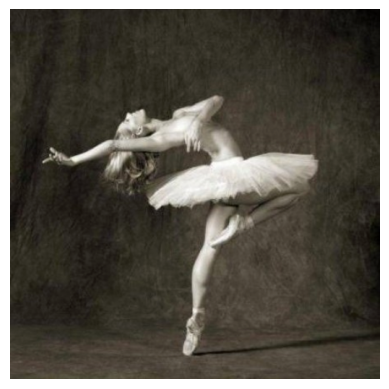

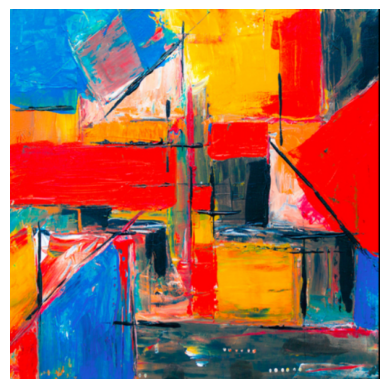

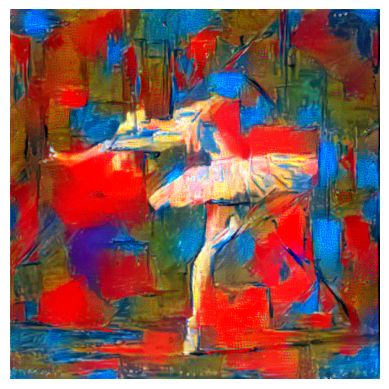

In [ ]:
plt.figure()
img_show(content_img)
plt.figure()
img_show(style_img)
plt.figure()
img_show(target_img)

Congratulations! Now you have your style transferred image.